In [8]:
#Libs
import pandas as pd
import numpy as np
from datetime import datetime
from IPython.display import display
import matplotlib as mpt
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [9]:
#import the data
filename_weather = "opsd-weather_data-2020-09-16\\weather_data.csv"

cols = ["utc_timestamp",
        "DE_temperature",
        "DE_radiation_direct_horizontal",
        "DE_radiation_diffuse_horizontal"]

df_de = pd.read_csv(filename_weather, usecols=cols)
df_de.head()

,utc_timestamp,DE_temperature,DE_radiation_direct_horizontal,DE_radiation_diffuse_horizontal
0,1980-01-01T00:00:00Z,-1.261,0.0,0.0
1,1980-01-01T01:00:00Z,-1.414,0.0,0.0
2,1980-01-01T02:00:00Z,-1.571,0.0,0.0
3,1980-01-01T03:00:00Z,-1.760,0.0,0.0
4,1980-01-01T04:00:00Z,-1.995,0.0,0.0


In [10]:
df_de["utc_timestamp"] = pd.to_datetime(df_de["utc_timestamp"])
df_de.set_index(df_de["utc_timestamp"], inplace=True)
df_de.drop(["utc_timestamp"], axis=1, inplace=True)
#Rename the columns with some easily accessible names
df_de.columns = ["Temp","Rad_direct", "Rad_diffuse" ]
df_de.index.name = "timestamp"
df_de.head()

,Temp,Rad_direct,Rad_diffuse
timestamp,,,
1980-01-01 00:00:00+00:00,-1.261,0.0,0.0
1980-01-01 01:00:00+00:00,-1.414,0.0,0.0
1980-01-01 02:00:00+00:00,-1.571,0.0,0.0
1980-01-01 03:00:00+00:00,-1.760,0.0,0.0
1980-01-01 04:00:00+00:00,-1.995,0.0,0.0


In [11]:
#dlai-tf course method
def prep_windowed_dataset(data, window_size, shift, batch_size, buffer_size=None):
    dataset=tf.data.Dataset.from_tensor_slices(data)
    dataset=dataset.window(window_size+1, shift=shift, drop_remainder=True)
    dataset=dataset.flat_map(lambda window: window.batch(window_size+1))
    if buffer_size:
        dataset=dataset.shuffle(buffer_size=buffer_size)
    dataset=dataset.map(lambda window: (window[:-1],window[-1]))
    dataset=dataset.batch(batch_size).prefetch(2)
    return dataset

In [12]:
#Using pandas shift

def prep_seq(data_in, in_steps=1, out_steps=1):
    df = pd.DataFrame(data_in)
    dff=df.copy()
    for i in range(1,in_steps+out_steps):
        shifted=df.shift(-i)
        dff=pd.concat([dff,shifted],axis=1).dropna()
    inputs, labels=dff.iloc[:,:-1].values, dff.iloc[:,-1].values.reshape(-1,1)
    return inputs, labels

#assumes last colum to be the label column (only one label in this case)
def prep_Seq(data_in, in_steps, out_steps):
    df_in=data_in.iloc[:,:-1].copy()
    df_out=data_in.iloc[:,-1].copy()
    for i in range(1,in_steps+out_steps):
        shifted=df_in.shift(-i)
        df_in=pd.concat([df_in,shifted],axis=1).dropna()
        shifted=df_out.shift(-i)
        df_out=pd.concat([df_out,shifted],axis=1).dropna()
    inputs, labels=df_in.values, df_out.iloc[:,-1].values.reshape(-1,1)
    return inputs, labels

In [ ]:
n_features=3
n_inputs = 6
n_labels=1

data = df_de["2014":"2018"][["Rad_direct", "Rad_diffuse", "Temp"]]

scaler=MinMaxScaler(feature_range=(0,1))
data_scaled=scaler.fit_transform(data)

data_scaled = pd.DataFrame(data_scaled)

X,y=prep_seq(data_scaled,n_inputs,n_labels)

print(X,y)
print(X.shape,y.shape)

datat = df_de["2019"][["Rad_direct", "Rad_diffuse", "Temp"]]

#scalert=MinMaxScaler(feature_range=(0,1))
#data_scaledt=scalert.fit_transform(datat)

#data_scaledt = pd.DataFrame(data_scaledt)

Xt,yt=prep_seq(datat,n_inputs,n_labels)

scalerxt=MinMaxScaler(feature_range=(0,1))
Xt=scalerxt.fit_transform(Xt)
scaleryt=MinMaxScaler(feature_range=(0,1))
yt=scaleryt.fit_transform(yt)


In [ ]:
#model for pandas made input
model_lstm_m=tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1)),
    tf.keras.layers.LSTM(16,activation='sigmoid'),
    tf.keras.layers.Dense(1)
])
model_lstm_m.compile(loss='mse',optimizer='adam')
history_lstm_m=model_lstm_m.fit(x=X,y=y,epochs=20)


In [ ]:
yhat_lstm_m=model_lstm_m.predict(Xt)
plt.figure(0)
plt.plot(history_lstm_m.history['loss'])
#print(yt,yhat_lstm_m)
plt.figure(1)
plt.plot(yt)
plt.plot(yhat_lstm_m)

In [ ]:
plt.plot(history_lstm_m.history['loss'][18:])

In [ ]:
plt.plot(scaleryt.inverse_transform(yt[1000:1050]))
plt.plot(scaleryt.inverse_transform(yhat_lstm_m[1000:1050]))

In [ ]:
num_hidden=3
num_classes=1

opt = tf.keras.optimizers.SGD(learning_rate=0.1)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(num_hidden, activation='relu'))
model.add(tf.keras.layers.Dense(num_classes, activation='relu'))
loss_fn = lambda: tf.keras.losses.mse(model(input), output)
var_list_fn = lambda: model.trainable_weights
for input, output in dataset.:
    opt.minimize(loss_fn, var_list_fn)


In [ ]:
datat.values[:10,-1]

In [47]:
#split data
train_data = df_de["2017"]["Temp"].values
val_data = df_de["2018"]["Temp"].values
test_data = df_de["2019"]["Temp"].values

print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

#prepare datasets for the model
window_size = 12
shift = 1
buffer_size = 2000
batch_size = 1
train_dataset = prep_windowed_dataset(train_data, window_size, shift, batch_size, buffer_size)
val_dataset = prep_windowed_dataset(val_data, window_size, shift, batch_size, buffer_size)
test_dataset = prep_windowed_dataset(test_data, window_size, shift, batch_size)

# create a single dense layer model - linear regression
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])

#optimizer = tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9)
optimizer = tf.keras.optimizers.Adagrad()

loss = "mse"
metrics = ["mae"]
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

forecasts_single = model.predict(test_dataset)

(8760,)
(8760,)
(8760,)
Epoch 1/10
8748/8748 [==============================] - 16s 2ms/step - loss: 78.7499 - mae: 6.8798 - val_loss: 33.3499 - val_mae: 4.7051
Epoch 2/10
8748/8748 [==============================] - 15s 2ms/step - loss: 24.6328 - mae: 4.1073 - val_loss: 26.6858 - val_mae: 4.2936
Epoch 3/10
8748/8748 [==============================] - 14s 2ms/step - loss: 21.8968 - mae: 3.9134 - val_loss: 25.2124 - val_mae: 4.1581
Epoch 4/10
8748/8748 [==============================] - 15s 2ms/step - loss: 20.9495 - mae: 3.8248 - val_loss: 24.2988 - val_mae: 4.0717
Epoch 5/10
8748/8748 [==============================] - 14s 2ms/step - loss: 20.2463 - mae: 3.7406 - val_loss: 23.5392 - val_mae: 4.0025
Epoch 6/10
8748/8748 [==============================] - 15s 2ms/step - loss: 19.4504 - mae: 3.6758 - val_loss: 22.8664 - val_mae: 3.9429
Epoch 7/10
8748/8748 [==============================] - 14s 2ms/step - loss: 18.7807 - mae: 3.6098 - val_loss: 22.2565 - val_mae: 3.8888
Epoch 8/10
8748/8

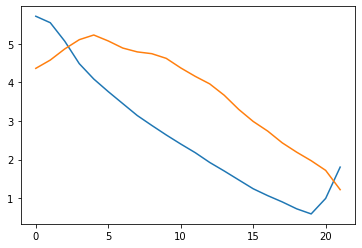

In [48]:
plt.figure(0)
plt.plot(test_data[12:12+22])
plt.plot(forecasts_single[:22])
plt.show()

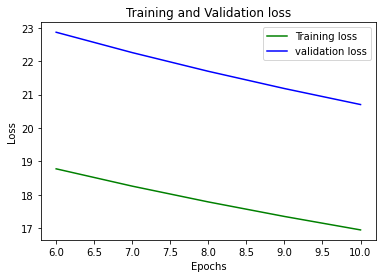

8.934022


In [49]:
loss_train = history.history['loss'][5:]
loss_val = history.history['val_loss'][5:]
epochs = range(6, 11)
plt.figure(1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(tf.keras.metrics.MAE(test_data[12:], forecasts_single).numpy().mean())

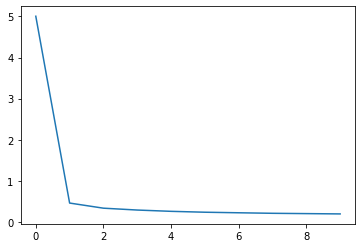

In [30]:
plt.plot(loss_train)

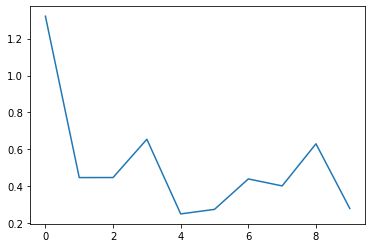

In [31]:
plt.plot(loss_val)

n =  1
Train: 0.135, Test: 0.229


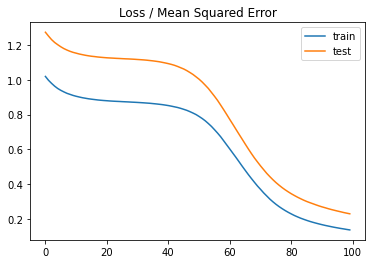

n =  2
Train: 0.070, Test: 0.079


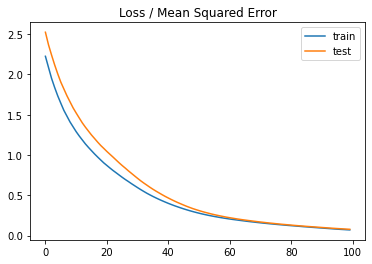

n =  5
Train: 0.040, Test: 0.065


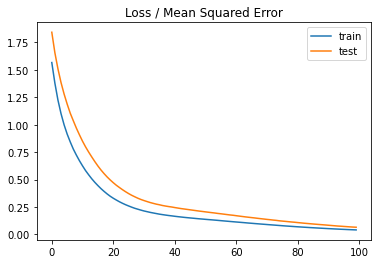

n =  10
Train: 0.016, Test: 0.028


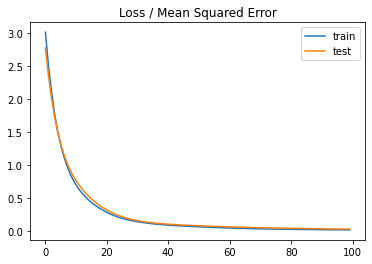

n =  15
Train: 0.012, Test: 0.033


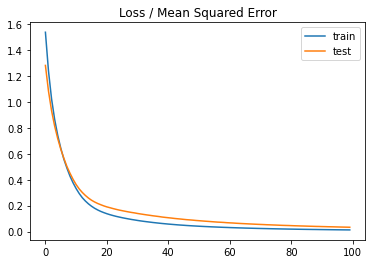

n =  20
Train: 0.017, Test: 0.047


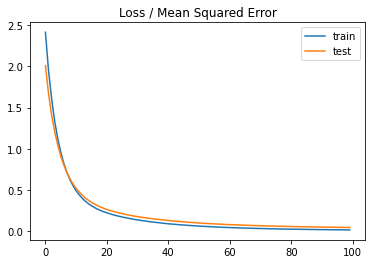

n =  30
Train: 0.009, Test: 0.044


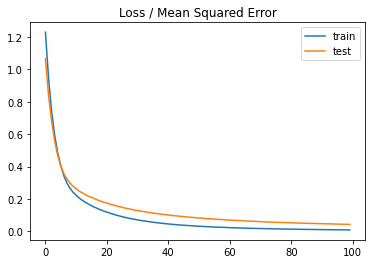

n =  40
Train: 0.010, Test: 0.059


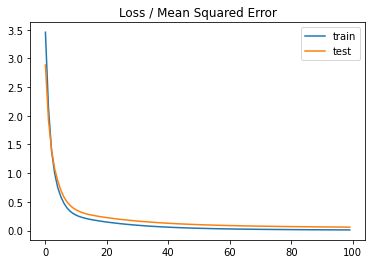

n =  80
Train: 0.004, Test: 0.050


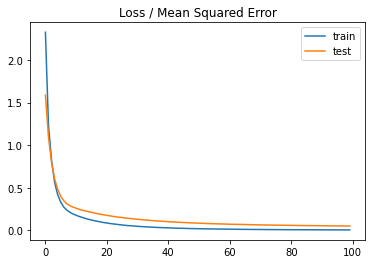

n =  100
Train: 0.002, Test: 0.042


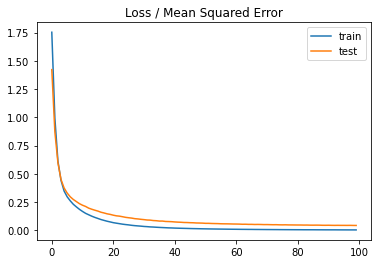

In [58]:
# mlp for regression with mse loss function
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from matplotlib import pyplot
import tensorflow
# generate regression dataset
X, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=1)
# standardize dataset
X = StandardScaler().fit_transform(X)
y = StandardScaler().fit_transform(y.reshape(len(y),1))[:,0]
# split into train and test
n_train = 500
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

neurons = [1,2,5,10,15,20,30,40,80,100]

for n in neurons:
    print("n = ",n)
    # define model
    model = Sequential()
    model.add(Dense(n, input_dim=20, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='linear'))
    opt = tensorflow.keras.optimizers.Adam()#SGD(lr=0.01, momentum=0.9)
    model.compile(loss='mean_squared_error', optimizer=opt)
    # fit model
    history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=100, verbose=0)
    # evaluate the model
    train_mse = model.evaluate(trainX, trainy, verbose=0)
    test_mse = model.evaluate(testX, testy, verbose=0)
    print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))
    # plot loss during training
    pyplot.title('Loss / Mean Squared Error')
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()